In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression

In [ ]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [ ]:
data.shape

(506, 13)

In [ ]:
data

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [ ]:
X = data[:, [0, 5]]
y = target

In [ ]:
# diabetes_data = load_diabetes(as_frame=True)

# X = diabetes_data['data'][['bmi', 'bp']].values
# y = diabetes_data['target'].values

In [ ]:
def get_bootstrap_sample(X, y):
    bootstrap_inds = np.random.choice(len(y), size=len(y), replace=True)
    return X[bootstrap_inds], y[bootstrap_inds]

In [ ]:
thetas_bs = []

for _ in range(1000):
    X_boot, y_boot = get_bootstrap_sample(X, y)

    model = LinearRegression()
    model.fit(X_boot, y_boot)

    thetas_bs.append([model.intercept_] + list(model.coef_))

thetas_bs = np.array(thetas_bs)

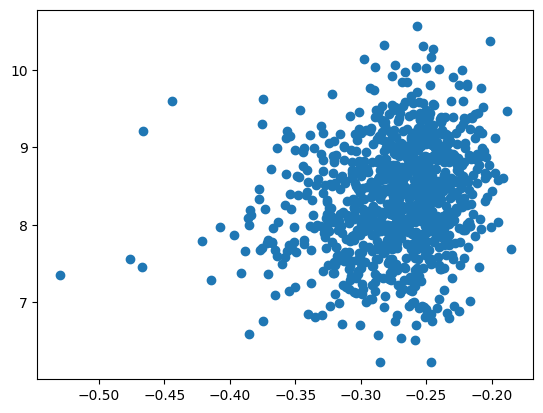

In [ ]:
plt.scatter(thetas_bs[:, 1], thetas_bs[:, 2])

In [ ]:
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

In [ ]:
amortized_bootstrap = nn.Sequential(
    nn.Linear(25, 50),
    nn.ReLU(),
    nn.Linear(50, 3)
)

In [ ]:
def reduce(inputs):
    res = 0
    for inp in inputs:
        res += inp
    return res / len(inputs)


def linear_model(theta, X):
    return X @ theta[1:] + theta[0]

In [ ]:
from tqdm.autonotebook import tqdm
T = 500
k = 3
latent_size = 25
gradient_steps = 100

optimizer = torch.optim.Adam(amortized_bootstrap.parameters(), lr=1e-3)
criterion = nn.MSELoss()

history = []
for t in tqdm(range(T)):
    bootstrap_samples = [get_bootstrap_sample(X_tensor, y_tensor) for _ in range(k)]

    X_k, y_k = zip(*bootstrap_samples)

    z_k = [torch.randn(latent_size) for _ in range(k)]

    epoch_loss = []
    for _ in range(gradient_steps):
        theta_k = [amortized_bootstrap(z) for z in z_k]

        y_pred_k = [linear_model(theta_cur, X_cur) for theta_cur, X_cur in zip(theta_k, X_k)]

        loss_k = [criterion(y_pred, y) for y_pred, y in zip(y_pred_k, y_k)]
        loss = reduce(loss_k)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

    history.append(np.mean(epoch_loss))

  0%|          | 0/500 [00:00<?, ?it/s]

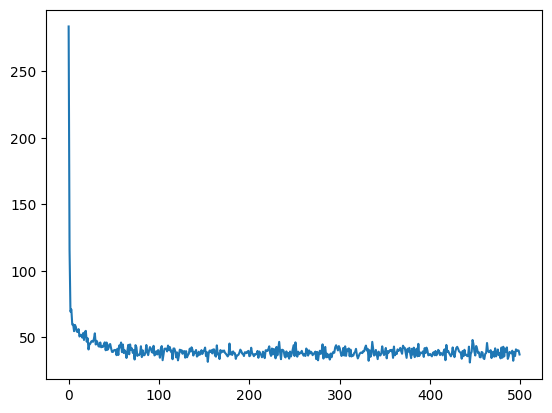

In [ ]:
plt.plot(history)

In [ ]:
z = torch.randn((1000, latent_size))

theta_pred = amortized_bootstrap(z).detach()

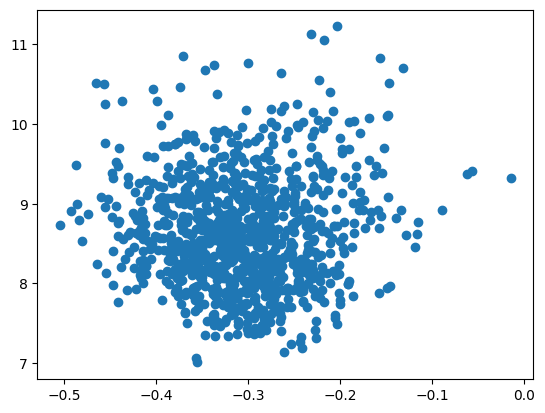

In [ ]:
plt.scatter(theta_pred[:, 1], theta_pred[:, 2])